In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve as convolveim
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

## PART 1 - correspondance in 2 images

In [39]:
img1 = cv2.imread('/content/drive/MyDrive/ca5/left.jpg',0).astype('float') # read left image
img_1 = cv2.normalize(img1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

descriptor_1, keypoints_1 = part_B(img_1)

img2 = cv2.imread('/content/drive/MyDrive/ca5/right.jpg',0).astype('float') # read right image
img_2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

descriptor_2, keypoints_2 = part_B(img_2)

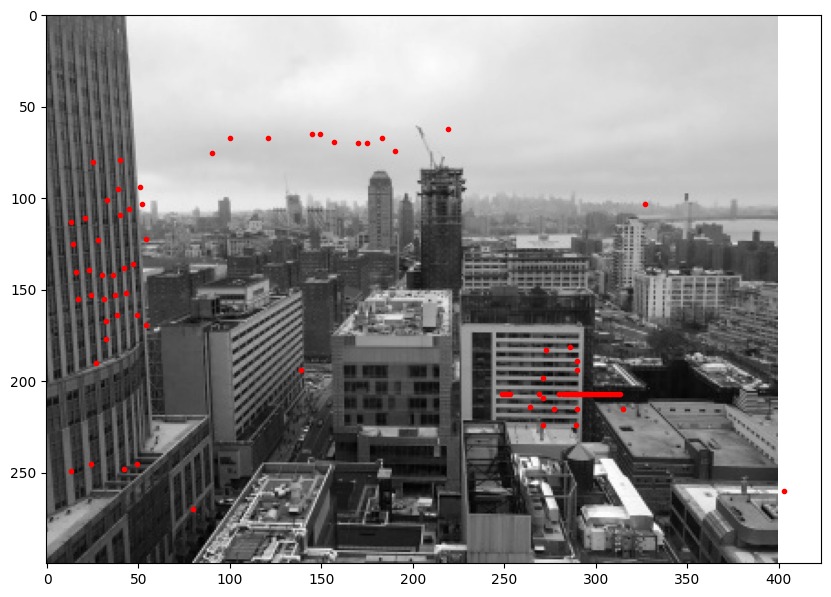

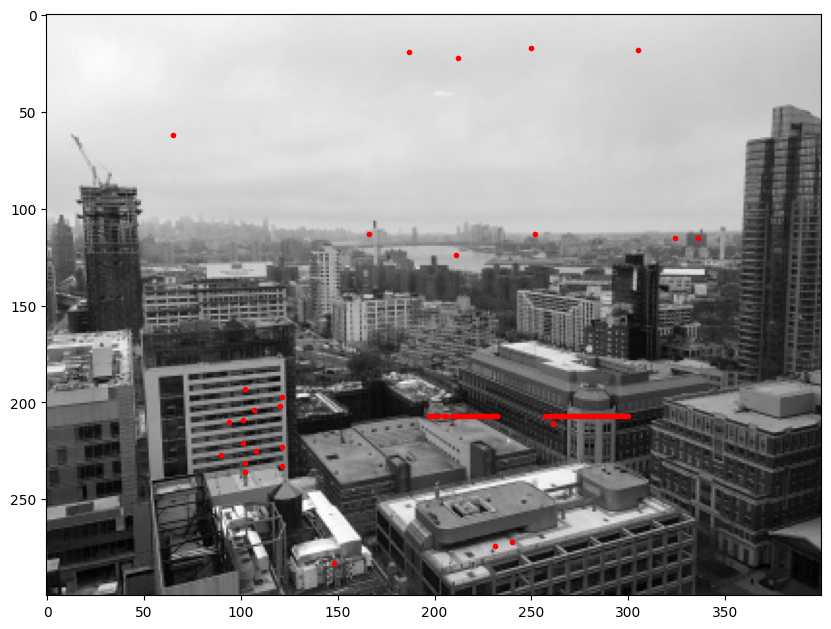

In [40]:
# Display detected points in the two images
plt.figure(figsize = (10,10))
plt.imshow(img_1,'gray')
plt.plot(keypoints_1[:,1],keypoints_1[:,0],'ro',ms=3)
plt.figure(figsize = (10,10))
plt.imshow(img_2,'gray')
plt.plot(keypoints_2[:,1],keypoints_2[:,0],'ro',ms=3)

threshold:  0.95
number of corresponding poitnts found: 81


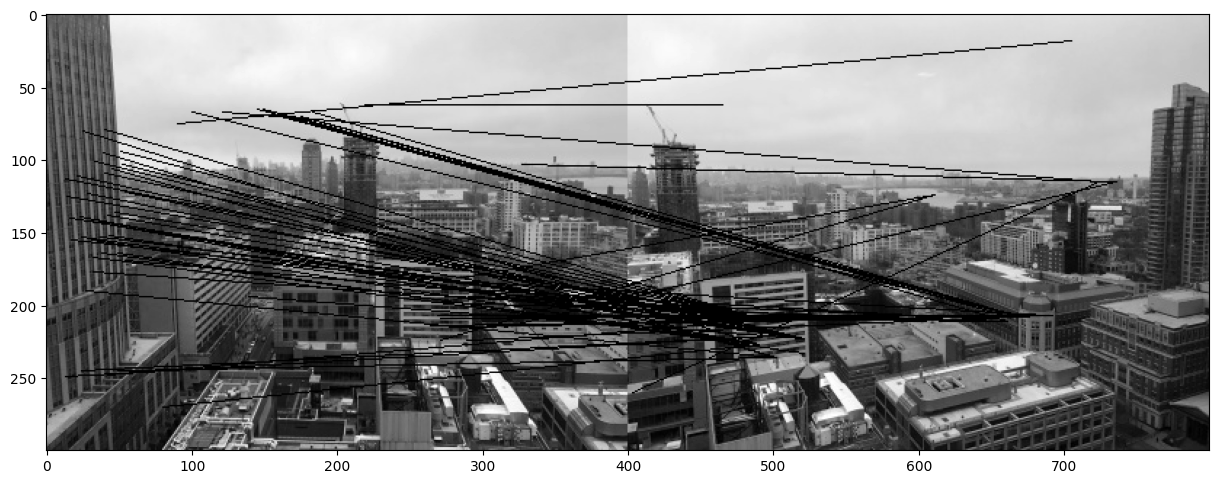

threshold:  0.8
number of corresponding poitnts found: 49


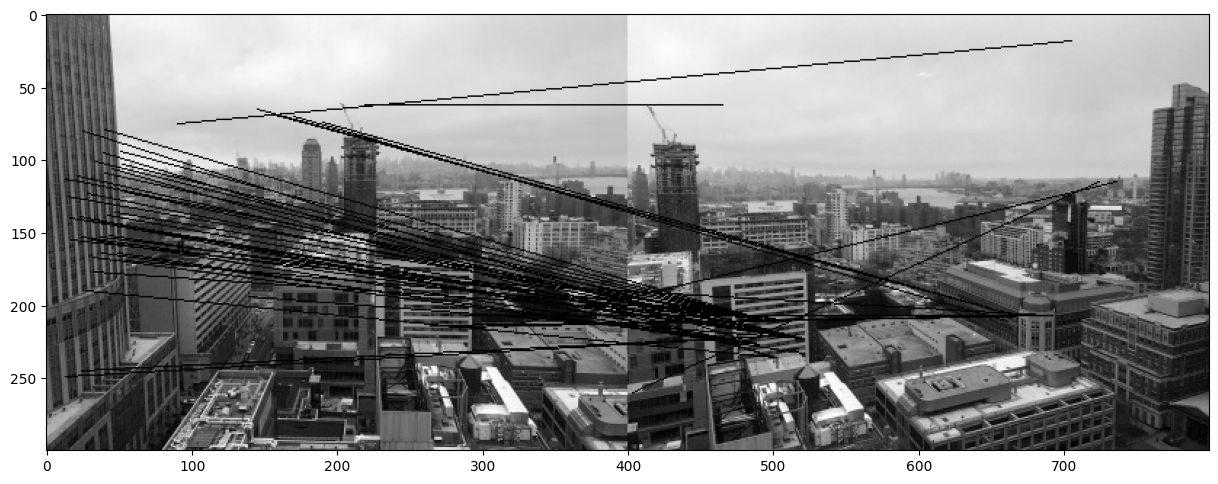

threshold:  0.65
number of corresponding poitnts found: 7


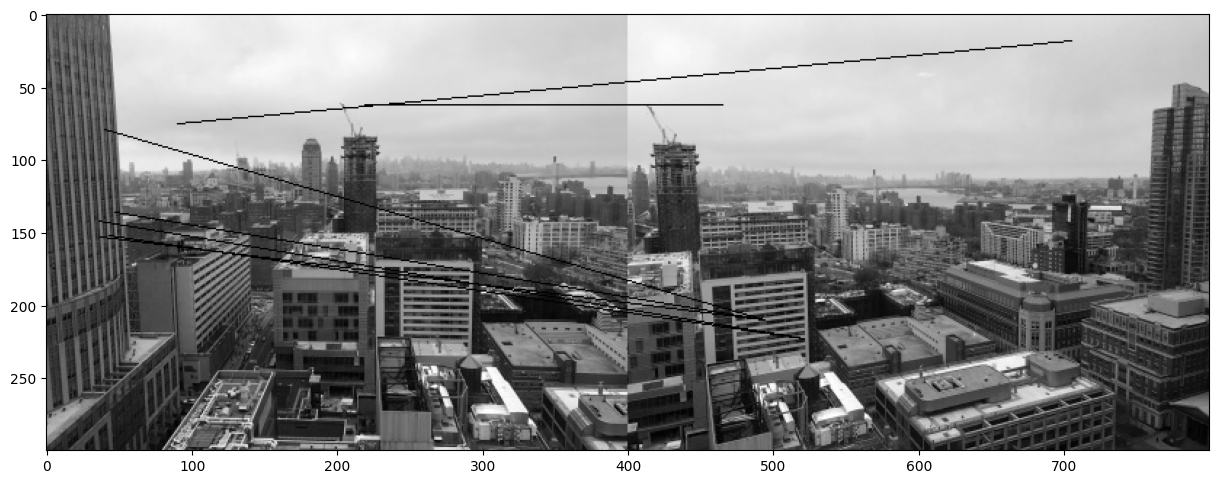

threshold:  0.5
number of corresponding poitnts found: 0


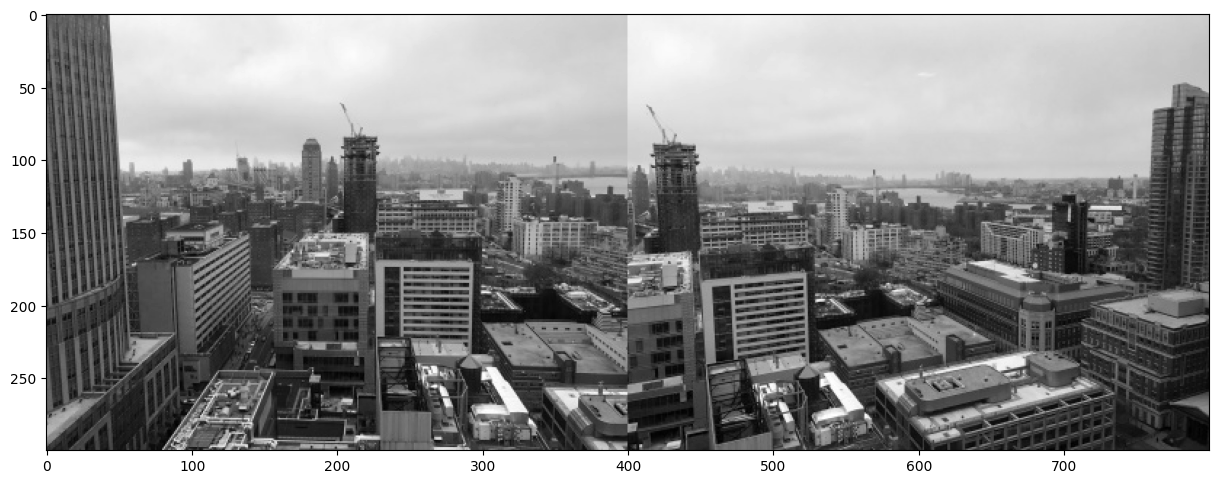

In [52]:
# write function to find corresponding points in image
def points_matching(kp1, descriptor1, kp2, descriptor2, threshold):
    matched_loca = list() # list of all corresponding points pairs. Point pairs can be stored as tuples
    ################################################ TODO ###############################################
    # Find matching points between img1 and img2 using the algorithm described in the above
    # For distance measuring, you may use np.linalg.norm()
    # You could implement it as nested loop for simplicity.

    for i in range(len(kp1)):
        dist = np.linalg.norm(descriptor1[i] - descriptor2, axis=1)
        min_dist = np.min(dist)
        min_idx = np.argmin(dist)
        if min_dist < threshold:
            matched_loca.append((kp1[i], kp2[min_idx]))

    return matched_loca


# Test different thresholds for the matching
for r in [0.95, 0.8, 0.65, 0.5]:
    matched_loca = points_matching(keypoints_1, descriptor_1, keypoints_2, descriptor_2, r)
    final_image = np.concatenate((img_1,img_2),axis=1)
    print('threshold: ', r)
    print('number of corresponding poitnts found:',len(matched_loca))
    ################################################ TODO ###############################################
    # Write code segment to draw lines joining corresponding points
    # Use cv2.line() to draw the line on final_image
    # Remember the x,y coordinate in numpy and OpenCV is opposite and you need to add image width for pt2
    for pt_pair in matched_loca:
        pt1, pt2 = pt_pair
        pt1_cv2 = (int(pt1[1]), int(pt1[0]))
        pt2_cv2 = (int(pt2[1] + img_1.shape[1]), int(pt2[0]))
        cv2.line(final_image, pt1_cv2, pt2_cv2, (0, 0, 255), 1)

    plt.figure(figsize=(15,15))
    plt.imshow(final_image,cmap='gray')
    plt.show()

## PART 2 - panorama stiching

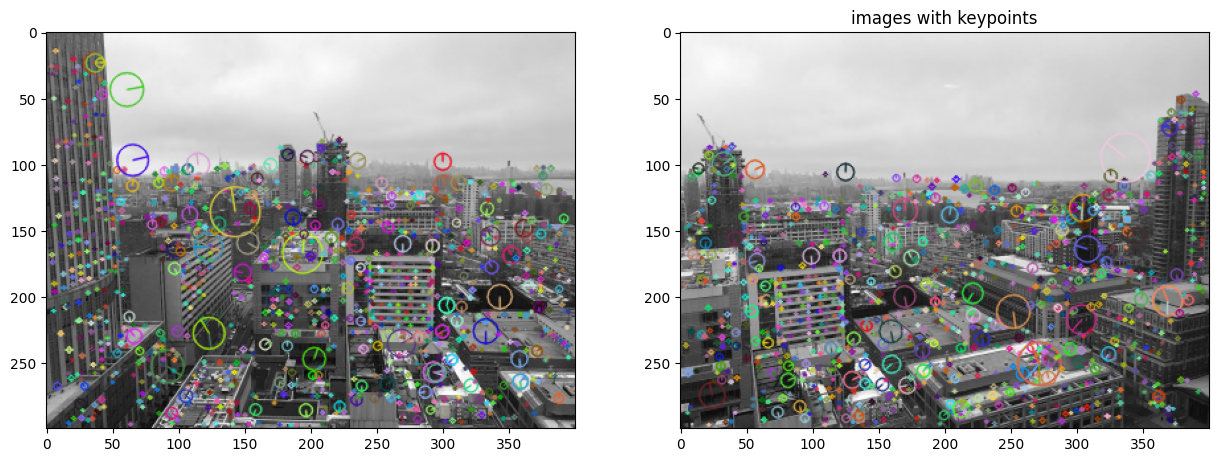

In [57]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status, lw=1):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (255, 255, 255), lw)
    # return the visualization
    return vis

img1 = cv2.imread('/content/drive/MyDrive/ca5/left.jpg',0)  # read left image
img2 = cv2.imread('/content/drive/MyDrive/ca5/right.jpg',0) # read right iamge

# Depending on your OpenCV version, you could set up SIFT differently
sift = cv2.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create()

################################################ TODO ###############################################
# Use sift.detect to detect features in the images
kp1 = sift.detect(img1, None)
kp2 = sift.detect(img2, None)

# Visualize the keypoints
img1_kps = cv2.drawKeypoints(img1,kp1,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kps = cv2.drawKeypoints(img2,kp2,None,flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img1_kps)
plt.subplot(122)
plt.imshow(img2_kps)
plt.title('images with keypoints')
plt.show()

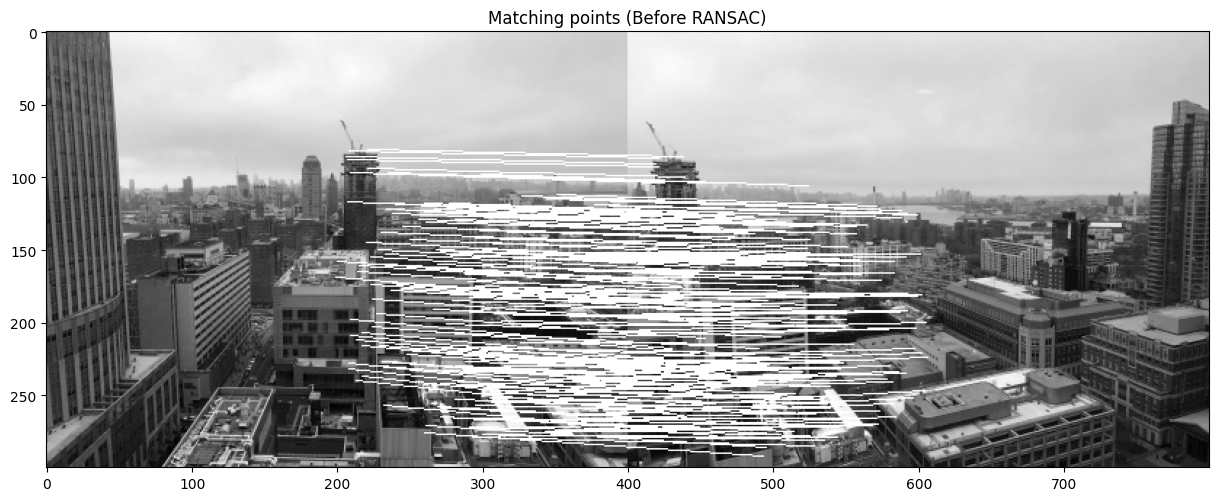

In [58]:
################################################ TODO ###############################################
# Use sift.compute to generate sift descriptors/features
(kp1, features1) = sift.compute(img1,kp1)
(kp2, features2) = sift.compute(img2,kp2)


kp1 = np.float32([kp.pt for kp in kp1])
kp2 = np.float32([kp.pt for kp in kp2])

matcher = cv2.DescriptorMatcher_create("BruteForce")
################################################ TODO ###############################################
# Use knnMatch function in matcher to find corresonding features
# For robustness of the matching results, we'd like to find 2 best matches (i.e. k=2 for knnMatch)
# and return their matching distances
rawMatches = matcher.knnMatch(features1,features2, k=2)
matches = []

# Now we validate if the matching is reliable by checking if the best maching distance is less than
# the second matching by a threshold, for example, 20% of the 2nd best maching distance
for m in rawMatches:
    ################################################ TODO ###############################################
    # Ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    # Test the distance between points. use m[0].distance and m[1].distance
    if len(m) == 2 and m[0].distance/m[1].distance < 0.5:
        matches.append((m[0].trainIdx, m[0].queryIdx))

ptsA = np.float32([kp1[i] for (_,i) in matches])
ptsB = np.float32([kp2[i] for (i,_) in matches])

################################################ TODO ###############################################
### Similar to what we did in part C
### Create an image img_match that shows the matching results by drawing lines between corresponding points.
img_match = drawMatches(img1, img2, kp1, kp2, matches, np.ones(len(matches)))

plt.figure(figsize=(15, 15))
plt.imshow(img_match, 'gray')
plt.title('Matching points (Before RANSAC)')
plt.show()


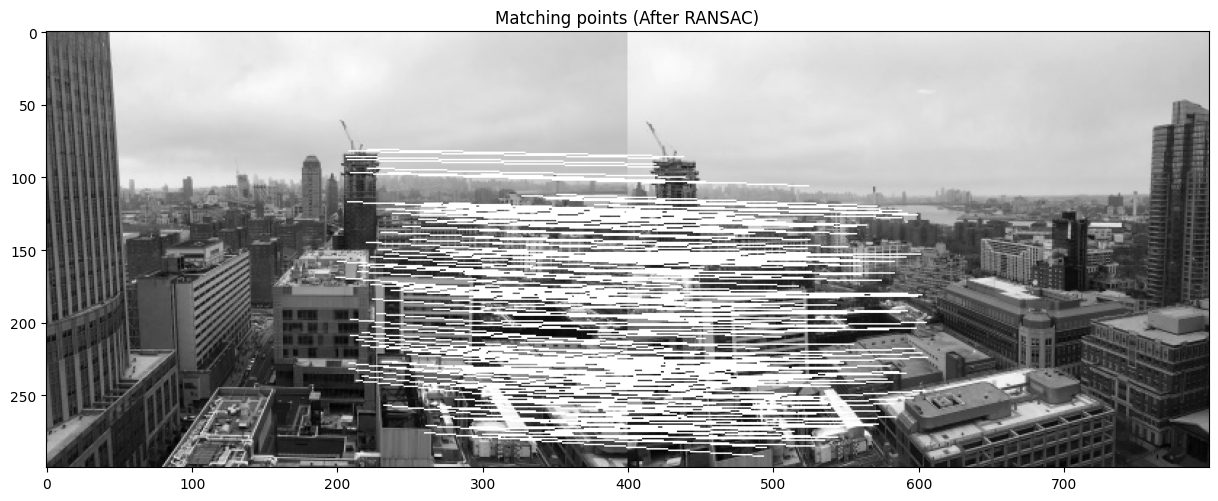

Text(0.5, 1.0, 'Stitched image')

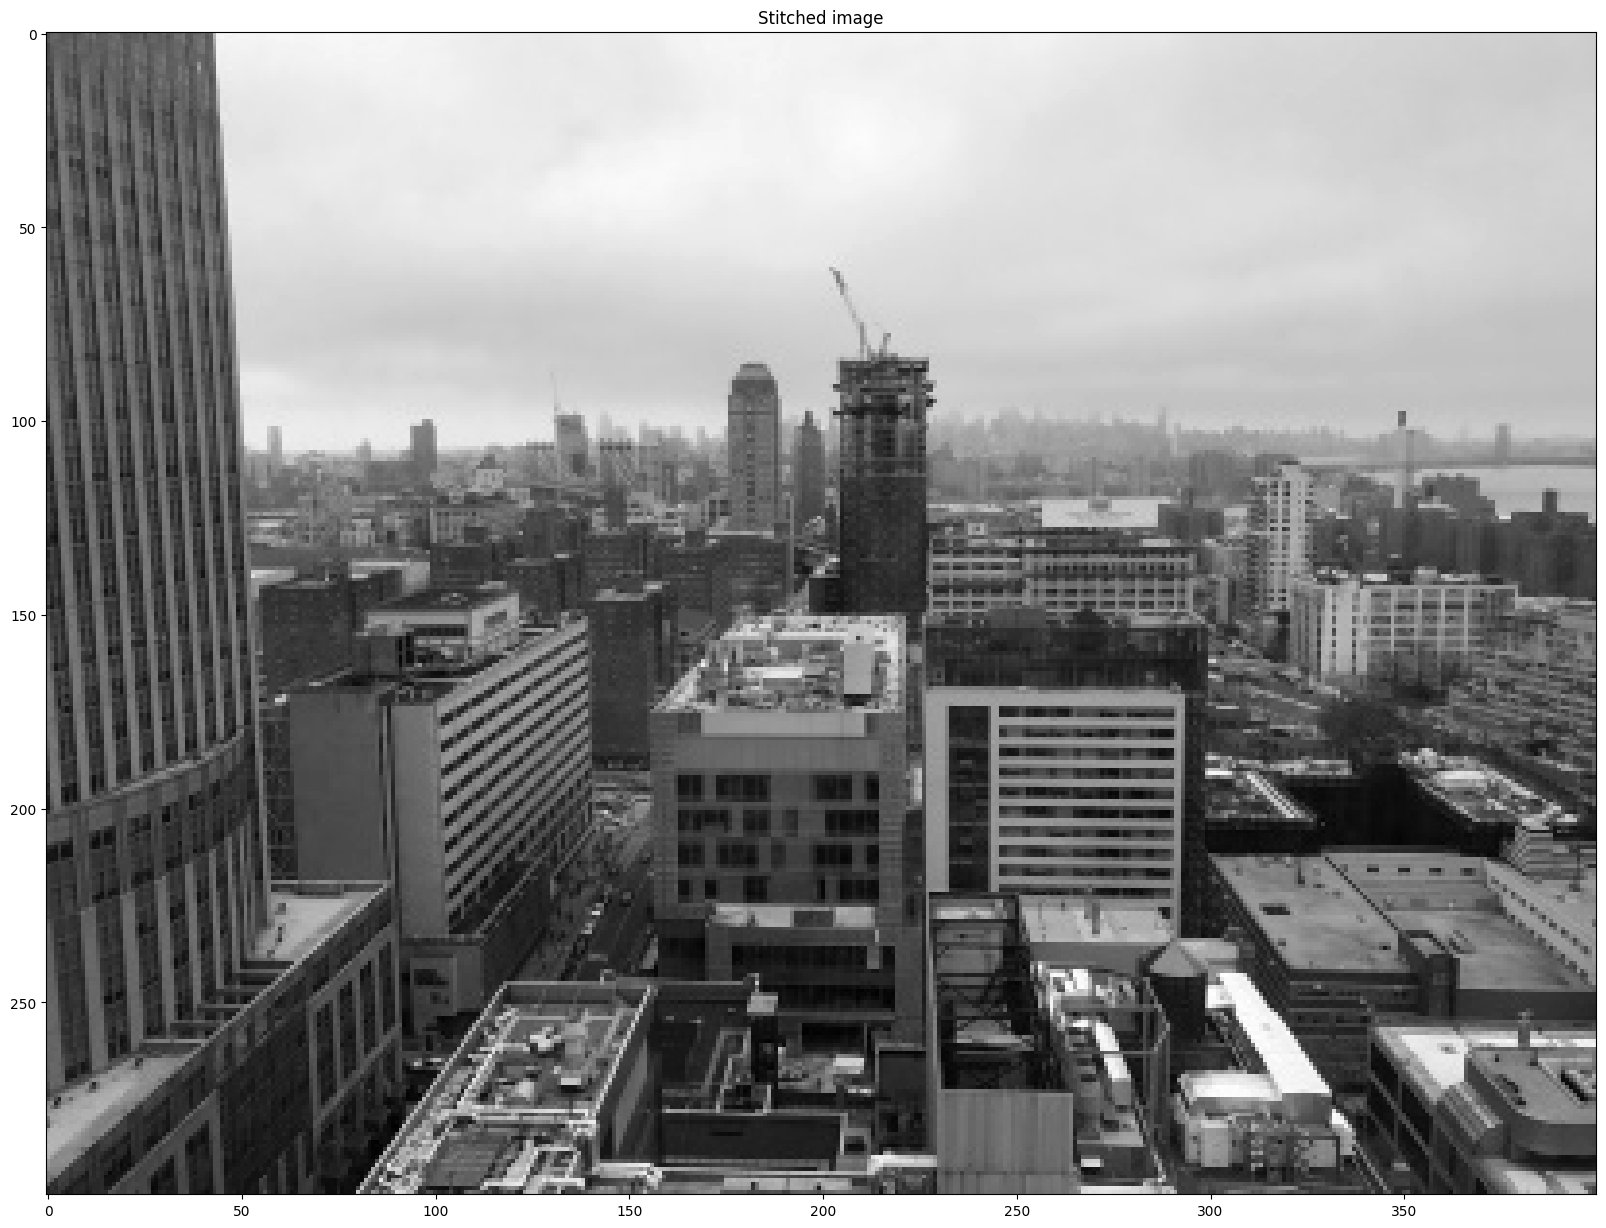

In [59]:
################################################ TODO ###############################################
# Find homography with RANSAC
(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,5.0)

img_ransac = drawMatches(img1,img2,kp1,kp2,matches,status)
plt.figure(figsize=(15,15))
plt.imshow(img_ransac,'gray')
plt.title('Matching points (After RANSAC)')
plt.show()

################################################ TODO ###############################################
# fill in the arguments to warp the second image to fit the first image.
# For the size of the resulting image, you can set the height to be the same as the original, width to be twice the original.
# First transform the right image, then fill in the left part with the orignal left image
result = cv2.warpPerspective(img2, H, (img2.shape[1], img2.shape[0]))
# For blending, you could just overlay img1 to the corresponding positions on warped img2
result[0:img2.shape[0], 0:img2.shape[1]] = img1

plt.figure(figsize=(20,40))
plt.imshow(result,'gray')
plt.title('Stitched image')